In [1]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D,Conv2DTranspose ,Flatten, Dense,  MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout, BatchNormalization, Reshape, Lambda, Activation
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


In [2]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt


In [3]:
from PIL import Image
import os
import cv2

In [4]:
anotations = pd.read_csv('the-simpsons-characters-dataset/annotation.txt', sep=",", header=None)
anotations['char_path'] = 'the-simpsons-characters-dataset'+anotations[0].str[1:]
anotations

,0,1,2,3,4,5,char_path
0,./characters/abraham_grampa_simpson/pic_0000.jpg,57,72,52,72,abraham_grampa_simpson,the-simpsons-characters-dataset/characters/abr...
1,./characters/abraham_grampa_simpson/pic_0001.jpg,80,31,337,354,abraham_grampa_simpson,the-simpsons-characters-dataset/characters/abr...
2,./characters/abraham_grampa_simpson/pic_0002.jpg,128,48,285,407,abraham_grampa_simpson,the-simpsons-characters-dataset/characters/abr...
3,./characters/abraham_grampa_simpson/pic_0003.jpg,72,126,158,275,abraham_grampa_simpson,the-simpsons-characters-dataset/characters/abr...
4,./characters/abraham_grampa_simpson/pic_0004.jpg,123,61,294,416,abraham_grampa_simpson,the-simpsons-characters-dataset/characters/abr...
...,...,...,...,...,...,...,...
6747,./characters/sideshow_bob/pic_0721.jpg,32,89,225,323,sideshow_bob,the-simpsons-characters-dataset/characters/sid...
6748,./characters/sideshow_bob/pic_0779.jpg,110,2,503,392,sideshow_bob,the-simpsons-characters-dataset/characters/sid...
6749,./characters/sideshow_bob/pic_0609.jpg,198,3,525,346,sideshow_bob,the-simpsons-characters-dataset/characters/sid...
6750,./characters/sideshow_bob/pic_0427.jpg,103,75,240,253,sideshow_bob,the-simpsons-characters-dataset/characters/sid...


In [5]:
anotations[5].value_counts()


charles_montgomery_burns    650
homer_simpson               612
abraham_grampa_simpson      595
ned_flanders                595
lisa_simpson                562
marge_simpson               557
bart_simpson                554
principal_skinner           506
krusty_the_clown            226
nelson_muntz                219
moe_szyslak                 215
kent_brockman               213
edna_krabappel              212
milhouse_van_houten         210
chief_wiggum                209
comic_book_guy              208
apu_nahasapeemapetilon      206
sideshow_bob                203
Name: 5, dtype: int64

## example on preprocessing data

In [6]:
img_rows=64
img_cols=64

(416, 576, 3)

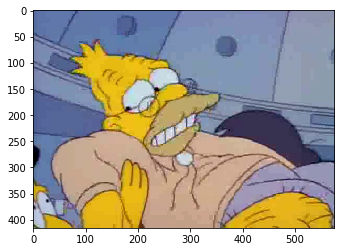

In [7]:
# test anotation
test_img = plt.imread(anotations['char_path'][0])
plt.imshow(test_img)
test_img.shape

(64, 64, 3)

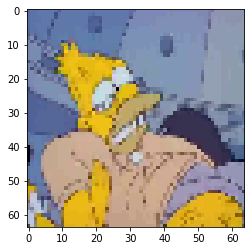

In [8]:
test_img = cv2.resize(test_img, (img_rows, img_cols)).astype('float32') / 255.
plt.imshow(test_img)
test_img.shape


# load all the data

In [9]:
img_rows=64
img_cols=64

Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path
Wrong file or file path


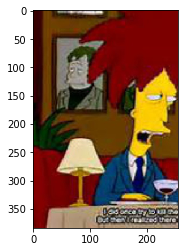

In [10]:
img_list = []
label_list = []
i = 0
for path in anotations['char_path'].unique():  
    try:
        img = plt.imread(path)
        plt.imshow(img)
        img = cv2.resize(img, (img_rows, img_cols)).astype('float32') / 255.
        img_list.append(img)
        label_list.append(anotations[5][i])
    except FileNotFoundError:
        print("Wrong file or file path")
    i = i+1


6720
(6720, 64, 64, 3)
(64, 64, 3)


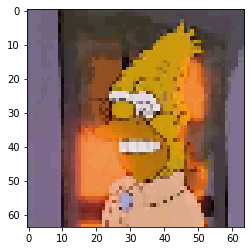

In [11]:
print(len(img_list))
image_data = np.ravel(img_list).reshape(len(img_list),img_rows,img_cols,3)
print(image_data.shape)
print(image_data[100].shape)
plt.imshow(image_data[100])


# Expand the dataset

# Build Autoencoder

In [12]:
X_train, X_test, y_train, y_test = train_test_split(image_data, label_list, test_size=0.33,
                                                    random_state=42, stratify=label_list)


In [13]:
input_dim = (img_rows,img_cols,3)

#Mejor combinación, 16, 32 conv, 8 intermedia
W = 64
K = 7
P=3
S=1
size = (W-K+2*P)/S +1
print(size)

64.0


In [14]:
encoder_input = Input(shape=input_dim, name='encoder_input')
x = encoder_input

x = Conv2D(filters=16, kernel_size=3, activation='relu',strides=1 ,padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
encoded = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(8, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, 3, activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(encoder_input, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0     

In [15]:
checkpoint = ModelCheckpoint('weights_autoencoder.h5', save_weights_only = True, save_best_only=True, verbose=1)

history = autoencoder.fit(X_train, X_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpoint])

Train on 4502 samples, validate on 2218 samples
Epoch 1/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6923
Epoch 00001: val_loss improved from inf to 0.69233, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 49s 11ms/sample - loss: 0.6923 - val_loss: 0.6923
Epoch 2/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6923
Epoch 00002: val_loss improved from 0.69233 to 0.69231, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 47s 10ms/sample - loss: 0.6923 - val_loss: 0.6923
Epoch 3/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6923
Epoch 00003: val_loss improved from 0.69231 to 0.69228, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 49s 11ms/sample - loss: 0.6923 - val_loss: 0.6923
Epoch 4/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6923
Epoch 00004: val_loss improved from 0.69228 to 0.69226, saving mod

4480/4502 [============================>.] - ETA: 0s - loss: 0.6913
Epoch 00031: val_loss improved from 0.69134 to 0.69130, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 39s 9ms/sample - loss: 0.6913 - val_loss: 0.6913
Epoch 32/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6913
Epoch 00032: val_loss improved from 0.69130 to 0.69125, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 39s 9ms/sample - loss: 0.6913 - val_loss: 0.6913
Epoch 33/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6912
Epoch 00033: val_loss improved from 0.69125 to 0.69121, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 39s 9ms/sample - loss: 0.6912 - val_loss: 0.6912
Epoch 34/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6912
Epoch 00034: val_loss improved from 0.69121 to 0.69116, saving model to weights_autoencoder.h5
4502/4502 [================

Epoch 62/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6897
Epoch 00062: val_loss improved from 0.68969 to 0.68963, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6897 - val_loss: 0.6896
Epoch 63/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6896
Epoch 00063: val_loss improved from 0.68963 to 0.68957, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6896 - val_loss: 0.6896
Epoch 64/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6896
Epoch 00064: val_loss improved from 0.68957 to 0.68951, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6896 - val_loss: 0.6895
Epoch 65/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6895
Epoch 00065: val_loss improved from 0.68951 to 0.68944, saving model to weights_autoencoder.h5
4502/4502 [===

Epoch 93/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6875
Epoch 00093: val_loss improved from 0.68748 to 0.68739, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6875 - val_loss: 0.6874
Epoch 94/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6874
Epoch 00094: val_loss improved from 0.68739 to 0.68731, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6874 - val_loss: 0.6873
Epoch 95/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6873
Epoch 00095: val_loss improved from 0.68731 to 0.68723, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6873 - val_loss: 0.6872
Epoch 96/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6872
Epoch 00096: val_loss improved from 0.68723 to 0.68715, saving model to weights_autoencoder.h5
4502/4502 [===

4480/4502 [============================>.] - ETA: 0s - loss: 0.6848
Epoch 00123: val_loss improved from 0.68477 to 0.68467, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 9ms/sample - loss: 0.6848 - val_loss: 0.6847
Epoch 124/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6847
Epoch 00124: val_loss improved from 0.68467 to 0.68458, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 125/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6846
Epoch 00125: val_loss improved from 0.68458 to 0.68448, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6846 - val_loss: 0.6845
Epoch 126/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6845
Epoch 00126: val_loss improved from 0.68448 to 0.68438, saving model to weights_autoencoder.h5
4502/4502 [=============

4480/4502 [============================>.] - ETA: 0s - loss: 0.6819
Epoch 00153: val_loss improved from 0.68187 to 0.68178, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6819 - val_loss: 0.6818
Epoch 154/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6818
Epoch 00154: val_loss improved from 0.68178 to 0.68169, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6818 - val_loss: 0.6817
Epoch 155/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6817
Epoch 00155: val_loss improved from 0.68169 to 0.68160, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6817 - val_loss: 0.6816
Epoch 156/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6816
Epoch 00156: val_loss improved from 0.68160 to 0.68151, saving model to weights_autoencoder.h5
4502/4502 [=============

4480/4502 [============================>.] - ETA: 0s - loss: 0.6795
Epoch 00183: val_loss improved from 0.67943 to 0.67935, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6795 - val_loss: 0.6794
Epoch 184/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6794
Epoch 00184: val_loss improved from 0.67935 to 0.67928, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 37s 8ms/sample - loss: 0.6794 - val_loss: 0.6793
Epoch 185/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6794
Epoch 00185: val_loss improved from 0.67928 to 0.67921, saving model to weights_autoencoder.h5
4502/4502 [==============================] - 38s 8ms/sample - loss: 0.6793 - val_loss: 0.6792
Epoch 186/200
4480/4502 [============================>.] - ETA: 0s - loss: 0.6793
Epoch 00186: val_loss improved from 0.67921 to 0.67915, saving model to weights_autoencoder.h5
4502/4502 [=============

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

(1, 64, 64, 3)


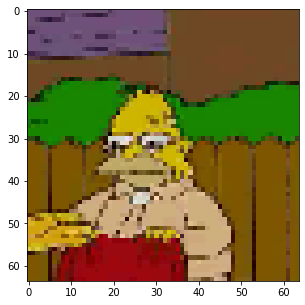

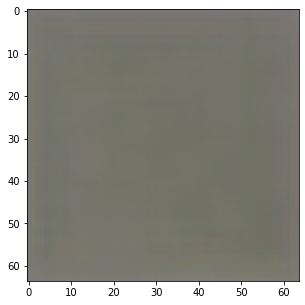

In [40]:
test_img = X_test[10:11,:,:,:]
reconstruction_img = autoencoder.predict(test_img)
print(reconstruction_img.shape)

plt.figure(figsize=(5,5))
plt.imshow(test_img[0])
plt.figure(figsize=(5,5))
plt.imshow(reconstruction_img[0])



array([[[[0.43529412, 0.3137255 , 0.47843137],
         [0.43529412, 0.3137255 , 0.47843137],
         [0.43529412, 0.3137255 , 0.47843137],
         ...,
         [0.42352942, 0.2901961 , 0.14509805],
         [0.42352942, 0.2901961 , 0.14509805],
         [0.42352942, 0.2901961 , 0.14509805]],

        [[0.43529412, 0.3137255 , 0.47843137],
         [0.43529412, 0.3137255 , 0.47843137],
         [0.43529412, 0.3137255 , 0.47843137],
         ...,
         [0.42352942, 0.2901961 , 0.14509805],
         [0.42352942, 0.2901961 , 0.14509805],
         [0.42352942, 0.2901961 , 0.14509805]],

        [[0.43137255, 0.3254902 , 0.45490196],
         [0.43137255, 0.3254902 , 0.45490196],
         [0.35686275, 0.2509804 , 0.38039216],
         ...,
         [0.43137255, 0.28235295, 0.14117648],
         [0.43137255, 0.28235295, 0.14117648],
         [0.43137255, 0.28235295, 0.14117648]],

        ...,

        [[0.49411765, 0.3372549 , 0.        ],
         [0.49411765, 0.3372549 , 0.        ]

## With different parameters